# PLS Regression Analysis for Multidimensional Poverty Estimation

This implementation develops a comprehensive modeling framework to estimate multidimensional poverty indicators using text-derived features from multiple data sources. The analysis employs Partial Least Squares (PLS) Regression to predict CONEVAL's official poverty statistics using real-time social media and news data.

## Data Integration

The analysis combines six distinct data sources across two temporal periods (2020 and 2022):

**Primary Data Sources:**
- **Google Trends**: Search volume patterns for poverty-related keywords
- **YouTube Comments**: Sentiment score and share of comments about each dimension of poverty 
- **Telegram Posts**: Share of posts about each dimension of poverty 
- **News Outlets**: LDA topic modeling of media coverage
- **Official Statistics**: CONEVAL poverty measurements (ground truth)

**Geographic Coverage**: All 32 Mexican states analyzed independently

**Temporal Scope**: 2020 and 2022 

## Methodology: Partial Least Squares Regression

### Why PLS Regression

**PLS Regression Advantages:**
- **Handle Multicollinearity**: Performs well with correlated predictor variables - and we believe this is our case, as we have different measures of the same dimension coming from different sources (e.g., the Telegram share of posts about the Food dimension might be correlated with the Youtube share of comments about the same dimension)
- **Dimensionality reduction**: Creates latent components that maximize covariance with target variables
- **Handle Small Samples with High Nuber of Variabls**: Optimal for our 64-observation dataset, with 45 variables. 

### Component Optimization

- 5-fold cross-validation with stratified sampling
- Mean squared error minimization objective
- Automatic boundary enforcement (components ≤ min(samples, features))

### Feature Engineering and Selection

**Feature Matrix Construction:**
- **Automated feature selection**: Excludes categorical variables and target columns
- **Numeric data types only**: Float64 and Int64 variables retained
- **Standardization**: Z-score normalization for all predictor variables

## Model Training and Validation

**Data Preparation:**
1. **Feature matrix assembly**: Combine all numeric predictors across data sources
2. **Target variable extraction**: CONEVAL official statistics as dependent variables
4. **Standardization**: Apply StandardScaler transformation to predictor matrix

**Model Fitting Process:**
```python
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
optimal_n = optimize_pls_components(X_scaled, y)
pls = PLSRegression(n_components=optimal_n, scale=False)
```

### Performance Evaluation 

**Primary Metrics:**
- **R-squared (R²)**: Explained variance in poverty indicators
- **Mean Absolute Error (MAE)**: Average prediction accuracy

**Validation Strategy:**
- **In-Sample Validation**: Test on 2022, which has been used to define coefficients 
- **State-level Predictions**: Individual state poverty nowcasting

In [1]:
# load necessary libraries
from sklearn.model_selection import KFold, cross_val_score
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

In [2]:
# load the data
tg_2020 = pd.read_csv('clean_data/tg_2020.csv')
tg_2022 = pd.read_csv('clean_data/tg_2022.csv')
gt_2020 = pd.read_csv('clean_data/gt_2020.csv')
gt_2022 = pd.read_csv('clean_data/gt_2022.csv')
yt_2020 = pd.read_csv('clean_data/yt_2020.csv')
yt_2022 = pd.read_csv('clean_data/yt_2022.csv')
news_2020 = pd.read_csv('clean_data/news_2020.csv')
news_2022 = pd.read_csv('clean_data/news_2022.csv')
off_2020 = pd.read_csv('clean_data/off_2020.csv')
off_2022 = pd.read_csv('clean_data/off_2022.csv')

In [3]:
# there were inconsistencies in the state names, so this mapping standardizes the state names across all datasets
state_name_map = {
    "México": "Estado de México",
    "Mexico": "Estado de México",
    "Estados Unidos Mexicanos": "Estado de México",
    "Michoacán de Ocampo": "Michoacán",
    "Veracruz de Ignacio de la Llave": "Veracruz",
    "Coahuila de Zaragoza": "Coahuila",
    "Yucatan": "Yucatán",
    "Queretaro": "Querétaro",
    "San Luis Potosi": "San Luis Potosí",
    "Nuevo Leon": "Nuevo León",
    "Michoacan": "Michoacán",
    "Michoacán de Ocampo": "Michoacán"}

# aplply the mapping
for df in [off_2020, off_2022, gt_2020, gt_2022, yt_2020, yt_2022, tg_2020, tg_2022, news_2020, news_2022]:
    df['state'] = df['state'].astype(str).str.strip()
    df['state'] = df['state'].replace(state_name_map)
    df['state'] = df['state'].replace("nan", None)  

# 'state' columns as strings in all dataframes
for df in [off_2020, off_2022, gt_2020, gt_2022, yt_2020, yt_2022, tg_2020, tg_2022, news_2020, news_2022]:
    df['state'] = df['state'].astype(str)

In [4]:
# create dataset for 2020
data_2020 = off_2020.copy()
data_2020['year'] = 2020

# merge Google Trends
data_2020 = data_2020.merge(gt_2020, on='state', how='inner')

# merge YouTube
data_2020 = data_2020.merge(yt_2020, on='state', how='inner')

# merge Telegram
data_2020 = data_2020.merge(tg_2020, on='state', how='inner')

# merge News (=LDA topics)
data_2020 = data_2020.merge(news_2020, on='state', how='inner')


# create dataset for 2022
data_2022 = off_2022.copy()
data_2022['year'] = 2022

# merge Google Trends
data_2022 = data_2022.merge(gt_2022, on='state', how='inner')

# merge YouTube
data_2022 = data_2022.merge(yt_2022, on='state', how='inner')

# merge Telegram
data_2022 = data_2022.merge(tg_2022, on='state', how='inner')

# merge News (=LDA topics)
data_2022 = data_2022.merge(news_2022, on='state', how='inner')

# combine datasets for 2020 and 2022
combined_data = pd.concat([data_2020, data_2022], ignore_index=True)

# check that we have all the states in both years (32 states * 2 years = 64 observations)
print(f"Number of observations: {len(combined_data)}")

Number of observations: 64


In [5]:
# map poverty dimensions to target columns
POVERTY_DIMENSIONS = {
    'income': 'income_target',
    'health': 'health_target',
    'education': 'educ_target',
    'social_security': 'social_target',
    'housing': 'housing_target',
    'food': 'food_target'}

In [6]:
# extract all feature columns excluding target columns and specific exclusions
def get_all_feature_columns(data, target_columns, exclude_cols=['state', 'year']):
    return [col for col in data.columns if col not in target_columns + exclude_cols and data[col].dtype in [np.float64, np.int64]]

In [7]:
# K-fold cross-validation to find optimal number of PLS components
def optimize_pls_components(X, y, max_components=10):
    max_components = min(max_components, len(X) - 1, X.shape[1])
    scores = []
    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    for n in range(1, max_components + 1):
        pls = PLSRegression(n_components=n, scale=False)
        mse = -cross_val_score(pls, X, y, cv=cv, scoring='neg_mean_squared_error').mean()
        scores.append(mse)

    return np.argmin(scores) + 1, scores

In [8]:
# fit the PLS model for a specific dimension
def fit_pls_dimension(data, dimension, target_col):

    all_targets = list(POVERTY_DIMENSIONS.values())
    feature_cols = get_all_feature_columns(data, all_targets)

    X = data[feature_cols].values
    y = data[target_col].values
    mask = ~(np.isnan(X).any(axis=1) | np.isnan(y))
    X, y = X[mask], y[mask]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    optimal_n, _ = optimize_pls_components(X_scaled, y)
    print(f"Optimal components: {optimal_n}")

    pls = PLSRegression(n_components=optimal_n, scale=False)
    pls.fit(X_scaled, y)
    y_pred = pls.predict(X_scaled).flatten()

    r2 = r2_score(y, y_pred)
    mae = mean_absolute_error(y, y_pred)

    print(f"R² = {r2:.3f}, MAE = {mae:.3f}")

    return {
        'dimension': dimension,
        'model': pls,
        'scaler': scaler,
        'feature_cols': feature_cols,
        'optimal_components': optimal_n,
        'X': X_scaled,
        'y_true': y,
        'y_pred': y_pred,
        'r2': r2,
        'states': data.loc[mask, 'state'].values,
        'years': data.loc[mask, 'year'].values}

# run PLS on all dimensions
pls_results = {}
for dim, target in POVERTY_DIMENSIONS.items():
    if target in combined_data.columns:
        result = fit_pls_dimension(combined_data, dim, target)
        if result:
            pls_results[dim] = result

Optimal components: 1
R² = 0.455, MAE = 7.929
Optimal components: 1
R² = 0.451, MAE = 6.718
Optimal components: 2
R² = 0.585, MAE = 2.599
Optimal components: 2
R² = 0.645, MAE = 6.497
Optimal components: 2
R² = 0.574, MAE = 5.294
Optimal components: 1
R² = 0.425, MAE = 4.053


In [9]:
# plot predicted vs true values for each dimension
def create_predictions_plot(pls_results):
    if not pls_results:
        return
    
    os.makedirs('pls_in_sample', exist_ok=True)
    
    # define color groups
    blue_group = ['housing', 'education', 'social_security']  # Blue - best performing dimensions
    green_group = ['income', 'food', 'health']               # Green - less performing dimensions
    
    # create individual plot for each dimension
    for dim, res in pls_results.items():
        # create single subplot
        fig, ax = plt.subplots(1, 1, figsize=(6, 6))
        
        # choose colors based on dimension group
        if dim in blue_group:
            point_color = 'steelblue'
            edge_color = 'darkblue'
        elif dim in green_group:
            point_color = 'forestgreen'
            edge_color = 'darkgreen'
        
        # scatter plot with group-specific colors
        ax.scatter(res['y_true'], res['y_pred'], alpha=0.7, s=80, 
                  color=point_color, edgecolors=edge_color)
        
        # perfect prediction line
        min_val = min(res['y_true'].min(), res['y_pred'].min())
        max_val = max(res['y_true'].max(), res['y_pred'].max())
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, alpha=0.8, label='Perfect prediction')
        
        # formatting
        ax.set_title(f"{dim.replace('_', ' ').title()}\nR² = {res['r2']:.3f}", fontsize=14, fontweight='bold')
        ax.set_xlabel("CONEVAL's statistics", fontsize=12)
        ax.set_ylabel("Predicted Values", fontsize=12)
        ax.grid(True, alpha=0.3)
        ax.legend()
        
        # make plot square
        ax.set_aspect('equal', adjustable='box')
        
        plt.tight_layout()
        
        # save plots
        filename = f'pls_in_sample/{dim}.png'
        plt.savefig(filename, dpi=300, bbox_inches='tight', facecolor='white')
        plt.show()

In [10]:
# in-sample performance: validate on 2022
def validate_2022_predictions(data, pls_results):
    data_2022 = data[data['year'] == 2022].copy()
    print(f"\nValidation on 2022 — {len(data_2022)} states")
    results = {}

    for dim, res in pls_results.items():
        print(f"\n--- {dim.upper()} ---")
        model = res['model']
        scaler = res['scaler']
        features = res['feature_cols']
        target = POVERTY_DIMENSIONS.get(dim)

        if target not in data_2022.columns:
            continue

        X = data_2022[features].values
        y = data_2022[target].values
        mask = ~(np.isnan(X).any(axis=1) | np.isnan(y))
        X, y = X[mask], y[mask]
        states = data_2022['state'].values[mask]

        if len(X) == 0:
            continue

        X_scaled = scaler.transform(X)
        y_pred = model.predict(X_scaled).flatten()

        r2 = r2_score(y, y_pred)
        mae = mean_absolute_error(y, y_pred)

        print(f"R² = {r2:.3f}, MAE = {mae:.3f}")

        results[dim] = {
            'states': states,
            'y_true': y,
            'y_pred': y_pred,
            'r2': r2,
            'mae': mae}

    return results

### Structured Results Export:

- **Predictions file:** State-level predictions with actual vs. predicted comparisons
- **Metrics summary:** Model performance statistics
- **Visualization suite:** Plots for each poverty dimension

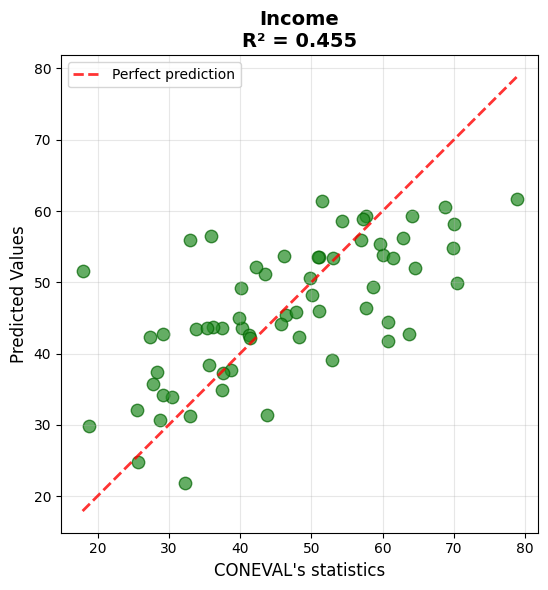

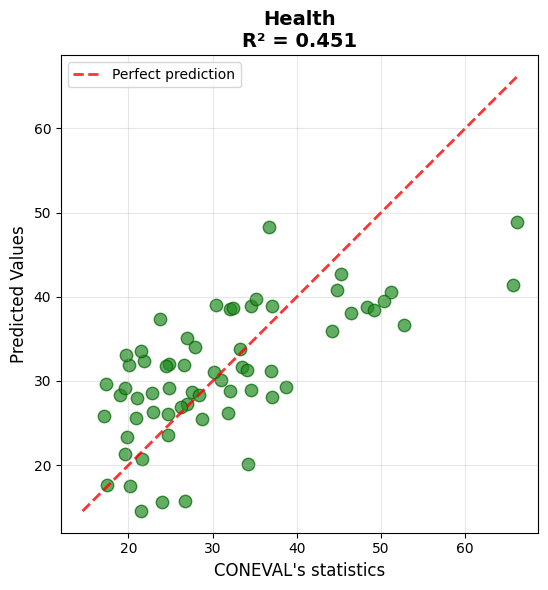

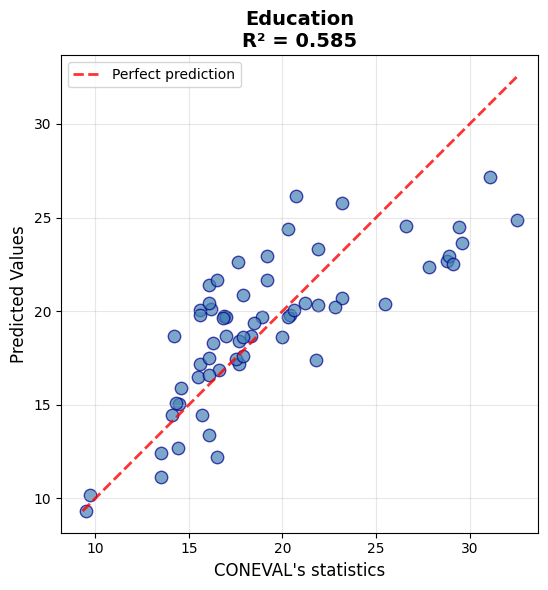

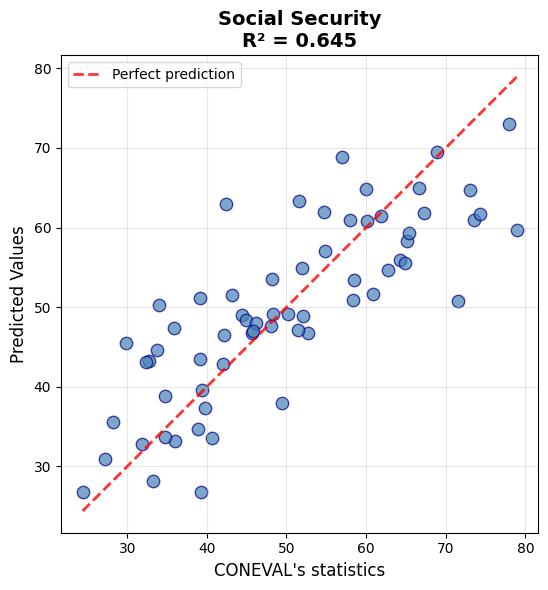

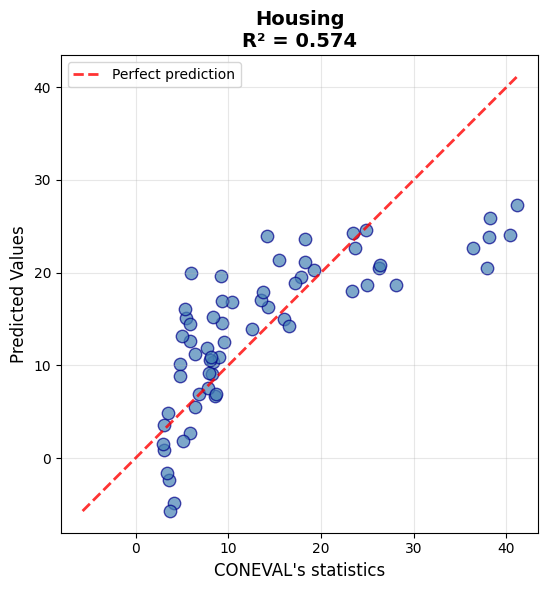

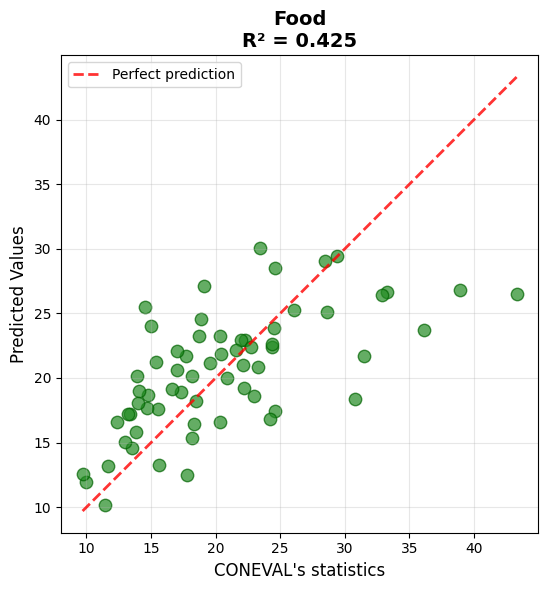


Validation on 2022 — 32 states

--- INCOME ---
R² = 0.341, MAE = 8.584

--- HEALTH ---
R² = 0.429, MAE = 7.702

--- EDUCATION ---
R² = 0.498, MAE = 2.887

--- SOCIAL_SECURITY ---
R² = 0.626, MAE = 6.716

--- HOUSING ---
R² = 0.567, MAE = 5.289

--- FOOD ---
R² = 0.386, MAE = 3.752


In [11]:
# save results and metrics
def save_results(pls_results, validation_results):

    # save nowcasts
    preds = {'state': next(iter(validation_results.values()))['states']}
    for dim, res in validation_results.items():
        preds[f'{dim}_actual'] = res['y_true']
        preds[f'{dim}_predicted'] = res['y_pred']
    pd.DataFrame(preds).to_csv("pls_in_sample/predictions.csv", index=False)

    # save metrics
    rows = []
    for dim, res in validation_results.items():
        rows.append({
            'dimension': dim,
            'r2': res['r2'],
            'mae': res['mae'],
            'features_used': pls_results[dim]['feature_cols']})
    pd.DataFrame(rows).to_csv("pls_in_sample/metrics.csv", index=False)

# complete pipeline
if pls_results:
    create_predictions_plot(pls_results)
    validation_2022 = validate_2022_predictions(combined_data, pls_results)
    if validation_2022:
        save_results(pls_results, validation_2022)

# Temporal Validation Approach: Training on 2020, Testing on 2022

As follows we implement an **out-of-sample validation strategy** that provides a more rigorous assessment of model generalization capabilities. Unlike the previous pooled approach, this methodology strictly separates training and testing periods to evaluate real-world nowcasting performance.

## Methodological Differences from Pooled Analysis

### **Training Data Isolation**
```python
def fit_pls_dimension_corrected(data, dimension, target_col):
    train_data = data[data['year'] == 2020].copy()  # Only 2020 for training
```

**Key Changes:**
- **Reduced training sample**: 32 observations (2020 only) vs. 64 observations (pooled)
- **Temporal consistency**: Model learns from historical patterns without future contamination
- **Realistic forecasting scenario**: Mimics operational deployment where we want to nowcast the year that just ended and so official statistics are not available

### **Standardization Protocol**
```python
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit scaler on 2020 data only
# Later in validation:
X_test_scaled = scaler.transform(X_test)        # Apply 2020 scaling to 2022 data
```

**Standardization Strategy:**
- **Scaler fitting**: Parameters calculated exclusively from 2020 training data
- **Test transformation**: 2022 data normalized using 2020 statistics

### **Cross-Validation Constraints**
```python
optimal_n, _ = optimize_pls_components(X_train_scaled, y_train)  # 5-fold CV on 2020 only
```

**Component Selection:**
- **Smaller optimization space**: Fewer components available due to reduced sample size
- **Overfitting risk**: Higher risk with 32 observations vs. 64 in pooled approach

## Implementation Considerations

In a real world application, weights should be defined with two years at least, meaning that one should always train on two years and then nowcast for another year. We could not do that since official statistics about muldimensional poverty were only available for 2018, 2020 and 2022, and our methodology did not allow use to perform our analysis for 2018 (i.e., scraping all the necessary sources). 

This implementation assumes poverty-text relationships remain consistent over time, and this caused our model to poorly perform on some dimensions due to Covid-19. Indeed, our model was trained only on 2020, during the pandemic, and so was not able to generalize to another year in which pandemic was no longer affecting the country.

In [12]:
# train PLS model on 2020 data only
def fit_pls_dimension(data, dimension, target_col):
    train_data = data[data['year'] == 2020].copy()
    
    all_targets = list(POVERTY_DIMENSIONS.values())
    feature_cols = get_all_feature_columns(train_data, all_targets)
    
    X_train = train_data[feature_cols].values
    y_train = train_data[target_col].values
    
    # standardize features 
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    
    # cross-validate to find optimal number of components
    optimal_n, _ = optimize_pls_components(X_train_scaled, y_train)
    print(f"Optimal components: {optimal_n}")
    
    # train PLS model
    pls = PLSRegression(n_components=optimal_n, scale=False)
    pls.fit(X_train_scaled, y_train)
    
    # predict on training data
    y_train_pred = pls.predict(X_train_scaled).flatten()
    train_r2 = r2_score(y_train, y_train_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    
    print(f"Training - R² = {train_r2:.3f}, MAE = {mean_absolute_error(y_train, y_train_pred):.3f}")
    
    return {
        'dimension': dimension,
        'model': pls,
        'scaler': scaler,
        'feature_cols': feature_cols,
        'optimal_components': optimal_n,
        'train_r2': train_r2, 
        'train_mae': train_mae,}

In [13]:
# validate PLS model on 2022 data
def validate_2022_predictions(data, pls_results):

    data_2022 = data[data['year'] == 2022].copy()
    results = {}
    
    for dim, res in pls_results.items():
        print(f"\n--- {dim.upper()} ---")
        model = res['model']
        scaler = res['scaler']  # scaler fitted on 2020 data 
        features = res['feature_cols']
        target = POVERTY_DIMENSIONS.get(dim)
        
        if target not in data_2022.columns:
            continue
        
        # 2022 data 
        X_test = data_2022[features].values
        y_test = data_2022[target].values
        mask = ~(np.isnan(X_test).any(axis=1) | np.isnan(y_test))
        X_test, y_test = X_test[mask], y_test[mask]
        states = data_2022['state'].values[mask]
        
        if len(X_test) == 0:
            continue
        
        # standardize features using the scaler fitted on 2020 data
        X_test_scaled = scaler.transform(X_test)
        
        # out-of-sample predictions
        y_pred = model.predict(X_test_scaled).flatten()
        
        # metrics for evaluation
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        
        print(f"Out-of-sample - R² = {r2:.3f}, MAE = {mae:.3f}")
        
        results[dim] = {
            'states': states,
            'y_true': y_test,
            'y_pred': y_pred,
            'r2': r2,
            'mae': mae,}
    
    return results

In [14]:
# plot predictions 2022 vs true values
def create_predictions_plot(pls_results):
    if not pls_results:
        return
    
    os.makedirs('pls_out_sample', exist_ok=True)
    
    # define color groups
    blue_group = ['housing', 'education', 'social_security']  # Blue - best performing dimensions
    green_group = ['income', 'food', 'health']               # Green - worst performing dimensions
    
    # create individual plot for each dimension
    for dim, res in pls_results.items():
        # create single subplot
        fig, ax = plt.subplots(1, 1, figsize=(6, 6))
        
        # choose colors based on dimension group
        if dim in blue_group:
            point_color = 'steelblue'
            edge_color = 'darkblue'
        elif dim in green_group:
            point_color = 'forestgreen'
            edge_color = 'darkgreen'
        
        # scatter plot with group-specific colors
        ax.scatter(res['y_true'], res['y_pred'], alpha=0.7, s=80, 
                  color=point_color, edgecolors=edge_color)
        
        # perfect prediction line
        min_val = min(res['y_true'].min(), res['y_pred'].min())
        max_val = max(res['y_true'].max(), res['y_pred'].max())
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, alpha=0.8, label='Perfect prediction')
        
        # formatting
        ax.set_title(f"{dim.replace('_', ' ').title()}\nR² = {res['r2']:.3f}", fontsize=14, fontweight='bold')
        ax.set_xlabel("CONEVAL's statistics", fontsize=12)
        ax.set_ylabel("Predicted Values", fontsize=12)
        ax.grid(True, alpha=0.3)
        ax.legend()
        
        # make plot square
        ax.set_aspect('equal', adjustable='box')
        
        plt.tight_layout()
        
        # save plots
        filename = f'pls_out_sample/{dim}.png'
        plt.savefig(filename, dpi=300, bbox_inches='tight', facecolor='white')
        plt.show()

=== TRAINING 2020 ===
Optimal components: 1
Training - R² = 0.507, MAE = 7.216
Optimal components: 1
Training - R² = 0.460, MAE = 3.702
Optimal components: 2
Training - R² = 0.692, MAE = 2.343
Optimal components: 1
Training - R² = 0.552, MAE = 7.393
Optimal components: 1
Training - R² = 0.456, MAE = 5.957
Optimal components: 1
Training - R² = 0.462, MAE = 4.143

=== VALIDATION 2022 ===

--- INCOME ---
Out-of-sample - R² = -0.268, MAE = 12.772

--- HEALTH ---
Out-of-sample - R² = -0.528, MAE = 11.761

--- EDUCATION ---
Out-of-sample - R² = 0.336, MAE = 3.324

--- SOCIAL_SECURITY ---
Out-of-sample - R² = 0.347, MAE = 9.498

--- HOUSING ---
Out-of-sample - R² = 0.399, MAE = 6.091

--- FOOD ---
Out-of-sample - R² = -0.297, MAE = 6.037


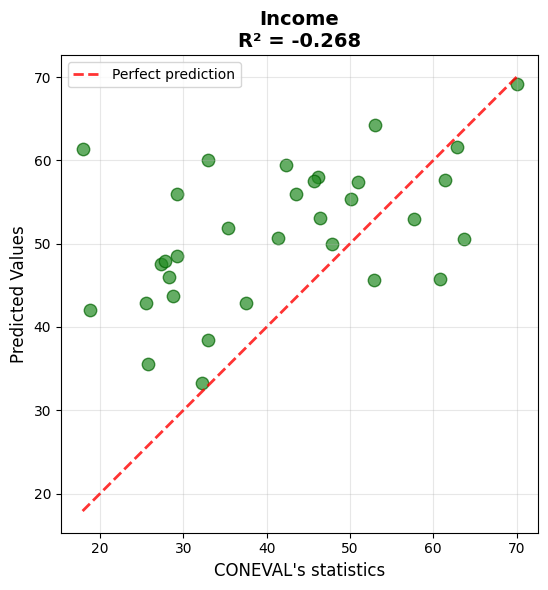

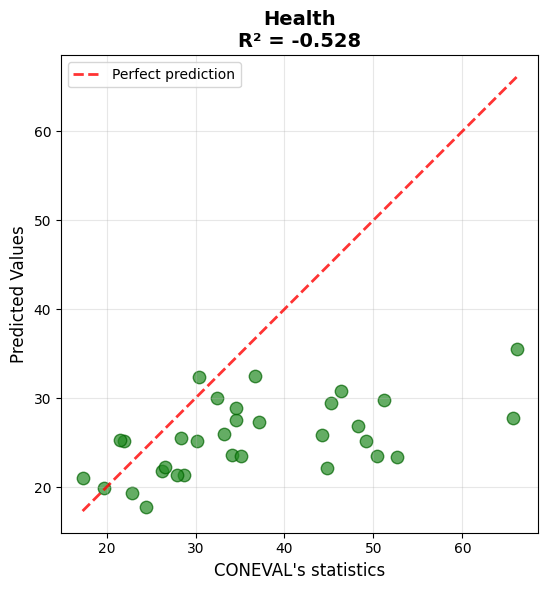

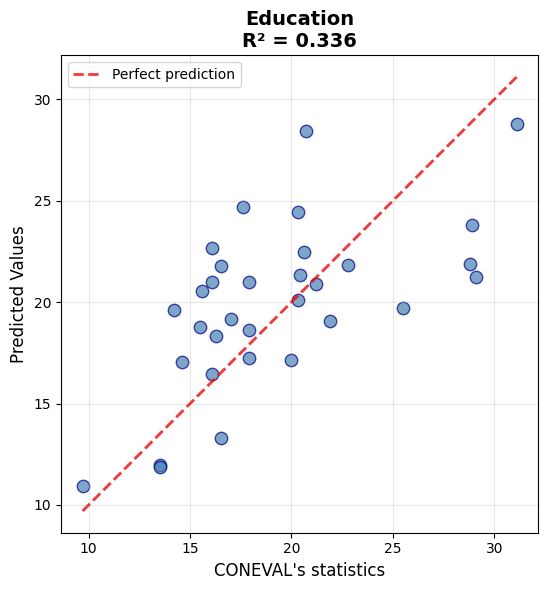

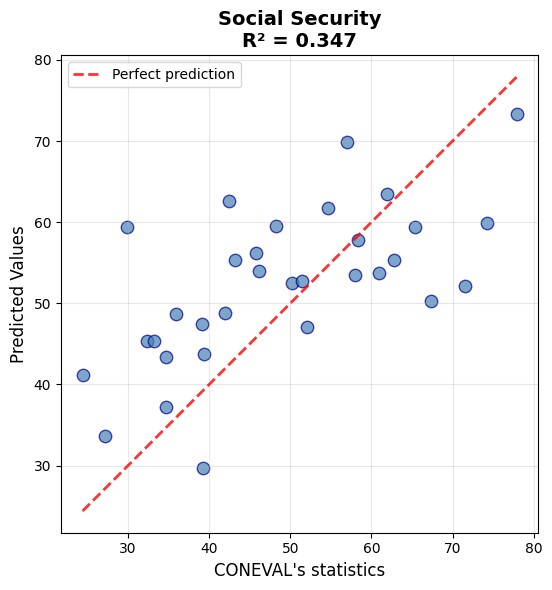

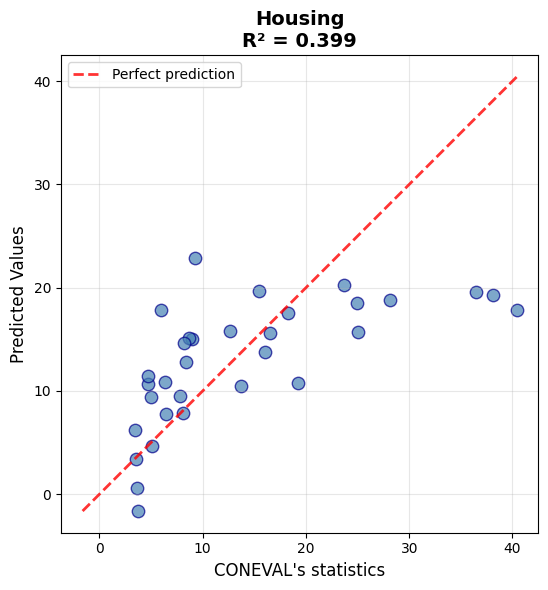

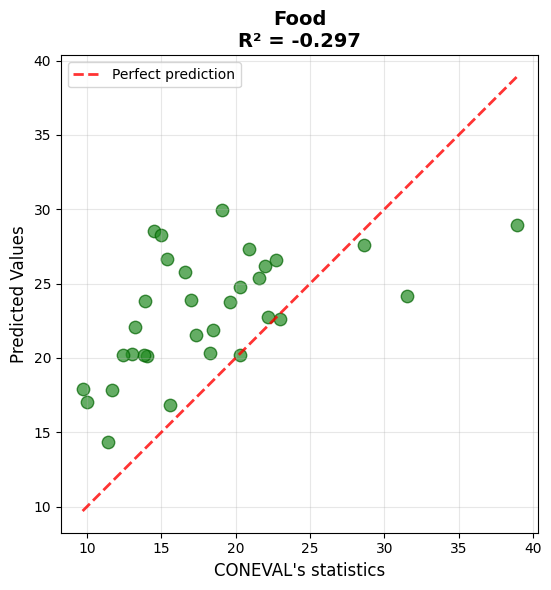

In [15]:
# save results
def save_results(pls_results, validation_results):
    os.makedirs('pls_out_sample', exist_ok=True)

    # save predictios
    preds = {'state': next(iter(validation_results.values()))['states']}
    for dim, res in validation_results.items():
        preds[f'{dim}_actual'] = res['y_true']
        preds[f'{dim}_predicted'] = res['y_pred']
    pd.DataFrame(preds).to_csv("pls_out_sample/predictions.csv", index=False)

    # save metrics
    rows = []
    for dim, res in validation_results.items():
        rows.append({
            'dimension': dim,
            'r2': res['r2'],
            'mae': res['mae'],
            'features_used': pls_results[dim]['feature_cols']
        })
    pd.DataFrame(rows).to_csv("pls_out_sample/metrics.csv", index=False)

# complete pipeline
print("=== TRAINING 2020 ===")
pls_results_corrected = {}
for dim, target in POVERTY_DIMENSIONS.items():
    if target in combined_data.columns:
        result = fit_pls_dimension(combined_data, dim, target)
        if result:
            pls_results_corrected[dim] = result

print("\n=== VALIDATION 2022 ===")
if pls_results_corrected:
    validation_2022 = validate_2022_predictions(combined_data, pls_results_corrected)
    if validation_2022:
        save_results(pls_results_corrected, validation_2022)
        create_predictions_plot(validation_2022)  